In [342]:
import requests
import json
import rasterio
from rasterio.plot import show
import rasterio.mask
import pyflwdir


import pyproj
from shapely.ops import transform
from shapely.geometry import shape, Point, GeometryCollection

x,y = -73.72435569763185, 43.17261895666325

NLDI_GEOSERVER_URL = 'https://labs.waterdata.usgs.gov/geoserver/wmadata/ows'

wkt_point = "POINT(%f %f)" %  (x , y)
cql_filter = "INTERSECTS(the_geom, %s)" % (wkt_point)

payload = {
    'service': 'wfs', 
    'version': '1.0.0', 
    'request': 'GetFeature', 
    'typeName': 'wmadata:catchmentsp', 
    'outputFormat': 'application/json',
    'srsName': 'EPSG:4326',
    'CQL_FILTER': cql_filter
}

#request catchment geometry from point in polygon query from NLDI geoserver
# https://labs.waterdata.usgs.gov/geoserver/wmadata/ows?service=wfs&version=1.0.0&request=GetFeature&typeName=wmadata%3Acatchmentsp&outputFormat=application%2Fjson&srsName=EPSG%3A4326&CQL_FILTER=INTERSECTS%28the_geom%2C+POINT%28-73.745860+44.006830%29%29
r = requests.get(NLDI_GEOSERVER_URL, params=payload)

#print('request url: ', r.url)
resp = r.json()

#get catchment id
catchmentIdentifier = json.dumps(resp['features'][0]['properties']['featureid'])

#get main catchment geometry polygon
features = resp['features']
catchment_geom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])


json.dumps(shapely.geometry.mapping(catchment_geom))

'{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[-73.7218, 43.1451], [-73.7216, 43.146], [-73.722, 43.1464], [-73.7241, 43.1467], [-73.7243, 43.1473], [-73.7247, 43.1482], [-73.7249, 43.1488], [-73.7255, 43.1494], [-73.7256, 43.1503], [-73.7257, 43.1506], [-73.727, 43.1494], [-73.7312, 43.1493], [-73.7317, 43.1494], [-73.7321, 43.15], [-73.7325, 43.1501], [-73.7337, 43.1504], [-73.7351, 43.1505], [-73.7359, 43.1501], [-73.7372, 43.1499], [-73.7363, 43.1521], [-73.7373, 43.1529], [-73.7378, 43.1535], [-73.7387, 43.1531], [-73.7418, 43.1534], [-73.743, 43.1541], [-73.744, 43.1547], [-73.7449, 43.1553], [-73.7465, 43.1561], [-73.7478, 43.1551], [-73.749, 43.155], [-73.7507, 43.1558], [-73.7533, 43.1552], [-73.7563, 43.1561], [-73.7581, 43.1548], [-73.7639, 43.1555], [-73.765, 43.1553], [-73.769, 43.1556], [-73.7703, 43.1565], [-73.7704, 43.158], [-73.77, 43.1588], [-73.7703, 43.1591], [-73.7702, 43.1616], [-73.7717, 43.1621], [-73.7722, 43.1628], [-73.7

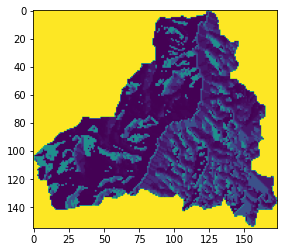

<AxesSubplot:>

In [337]:
#clip raster
with rasterio.open('./data/nhdplus/NHDPlusMA/NHDPlus02/NHDPlusFdrFac02b/fdr', 'r') as ds:
    dest_crs = ds.crs
    latlon = src.crs.to_epsg() == 4326

    wgs84 = pyproj.CRS('EPSG:4326')

    project_to_raster = pyproj.Transformer.from_crs(wgs84, dest_crs, always_xy=True).transform
    project_to_wgs84 = pyproj.Transformer.from_crs(dest_crs, wgs84, always_xy=True).transform
    projected_catchment_geom = transform(project_to_raster, catchment_geom)

    flwdir, flwdir_transform = rasterio.mask.mask(ds, projected_catchment_geom, crop=True)
    
flw = pyflwdir.from_array(flwdir[0], ftype='d8', transform=flwdir_transform, latlon=latlon)

# print(flw)

show(flwdir)

{"type": "Point", "coordinates": [-73.72435569763185, 43.17261895666325]}
original point: POINT (-73.72435569763185 43.17261895666325)
projected point: POINT (1785356.681280617 2452189.127095111)


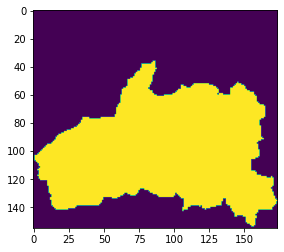

'{"type": "Polygon", "coordinates": [[[-73.73523474192233, 43.17753955477287], [-73.73463783410426, 43.18269614941896], [-73.73234452780709, 43.18659540047691], [-73.73092650779591, 43.187022272531586], [-73.72386813082305, 43.185635], [-73.7182448000254, 43.18619518282422], [-73.71646259950545, 43.18492551402752], [-73.71646917112577, 43.181090806106646], [-73.7144388722384, 43.179332360856236], [-73.71253348704273, 43.178735980454725], [-73.71416026660775, 43.176748814561314], [-73.71386933660473, 43.174486639515], [-73.71691624460173, 43.172681050695296], [-73.7156931723357, 43.17222502710863], [-73.71557864579188, 43.17148232314219], [-73.71735839745847, 43.170730699692484], [-73.71819134661703, 43.1694550926848], [-73.72071391184178, 43.169948299540415], [-73.72061884119638, 43.17105372031011], [-73.72168524449651, 43.171984117426966], [-73.72655949611689, 43.17309828067789], [-73.727672954231, 43.172508598213724], [-73.72983632278387, 43.17336343607279], [-73.73026941378964, 43.1

In [359]:
import numpy as np
from shapely.geometry import shape, Point, Polygon
import json

point_geom = Point(x,y)

print(json.dumps(shapely.geometry.mapping(point_geom)))

print('original point:',point_geom)

projected_point = transform(project_to_raster, point_geom)

print('projected point:',projected_point)

xy = projected_point.coords[:][0]

stream_order = flw.stream_order()

# delineate subbasins
subbasins = flw.basins(xy=xy, streams=stream_order>4)

#convert subbasins from uint32
subbasins = subbasins.astype(np.int16)
show(subbasins)

#convert raster to features
mask = subbasins != 0
polys = rasterio.features.shapes(subbasins, transform=flwdir_transform, mask=mask)

#just get one we want [not sure why we need to grab this]
poly = next(polys)



d = 0.00045 # distance
cf = 1.3  # cofactor

#project back to wgs84
split_geom = transform(project_to_wgs84, shape(poly[0])).simplify(d)



diff = catchment_geom.difference(split_geom).buffer(-d).buffer(d*cf).simplify(d)


json.dumps(shapely.geometry.mapping(diff ))



In [308]:
NLDI_URL = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/comid/'

#request upstream basin
payload = {'f': 'json', 'simplified': 'false'}

#request upstream basin from NLDI using comid of catchment point is in
r = requests.get(NLDI_URL + catchmentIdentifier + '/basin', params=payload)

#print('upstream basin', r.text)
resp = r.json()

#get main catchment geometry polygon
features = resp['features']
upstream_geom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

final = upstream_geom.difference(diff).buffer(-d).buffer(d*cf).simplify(d)


json.dumps(shapely.geometry.mapping(final))

'{"type": "Polygon", "coordinates": [[[-74.64647979574168, 43.40153499975773], [-74.64630804900857, 43.40308206010183], [-74.64527145877119, 43.404911378938046], [-74.64110026741186, 43.407154611937926], [-74.63958505890186, 43.4070432957701], [-74.63783646269722, 43.405820003082766], [-74.63132210373914, 43.40859377345065], [-74.62775110827933, 43.40950355097283], [-74.62154768330115, 43.40919274707382], [-74.61642797690419, 43.410226035786025], [-74.61253560824706, 43.41057470975388], [-74.61143020301097, 43.41100650875627], [-74.61120181019095, 43.414053049653134], [-74.60961430113147, 43.41526163992532], [-74.60736247544854, 43.415357274934976], [-74.60601140369418, 43.41577832863536], [-74.60297144155115, 43.41942992178594], [-74.60285827766965, 43.420240201146], [-74.60427360995418, 43.42266813816602], [-74.60408667082285, 43.424013634452], [-74.6035691956745, 43.42458128130649], [-74.60342986591758, 43.42585007761024], [-74.60303045338883, 43.42658452023697], [-74.59905294513996